<a href="https://colab.research.google.com/github/imadeardanabapeten/Analisis-Sentimen-Aplikasi-Access-by-KAI/blob/main/Analisis_Sentimen_Access_by_KAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Import Library***

In [2]:
# === Data handling ===
import pandas as pd
import numpy as np
import re

# === Visualisasi ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning (SVM) ===
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ***Load Data Hasil Scraping***

In [5]:
df = pd.read_csv("hasil_scraper_ulasan_APP_1.csv")

# Cek 10 data teratas
df.head(50)

,reviewId,userName,rating,review_txt,date
0,d4e4902d-5b78-46b3-adf3-ff69e8f76430,Pengguna Google,5,bagus banget,2026-02-04 13:16:13
1,5b2dc292-306f-4a3c-86a7-3e89f1a8bc92,Pengguna Google,5,mantap,2026-02-04 12:49:36
2,5737aa63-e8f9-47d1-9c7b-363c0aba881b,Pengguna Google,5,luar biasa...mantap... terimakasih pelayanan nya,2026-02-04 12:13:15
3,91bef259-f403-4483-996c-8231a42e6ba8,Pengguna Google,1,makin di-update makin banyak masalah nya,2026-02-04 11:24:02
4,cd27b68a-fdac-474f-8b62-de861f3af48c,Pengguna Google,5,"sebenarnya aplikasi ini memudahkan,tp knp bebe...",2026-02-04 09:45:24
5,3133fcd5-7ebb-4abe-9032-35faaeecb443,Pengguna Google,5,sngt membatu,2026-02-04 08:41:29
6,823e3abc-343d-4ea6-a41c-24307dddeb2c,Pengguna Google,5,kenapa war tiket lebaran tahun ini susah bange...,2026-02-04 08:33:13
7,6c267913-399d-4637-b314-09ca266fa632,Pengguna Google,5,cepat,2026-02-04 08:02:44
8,fed9b129-2536-47ec-b349-bccb597bdf72,Pengguna Google,5,mantap,2026-02-04 07:30:16
9,5ad20112-84c0-4fc3-a11b-5130882ea6f1,Pengguna Google,5,good,2026-02-04 05:51:30


# ***Analisis Distribusi Rating Pengguna***

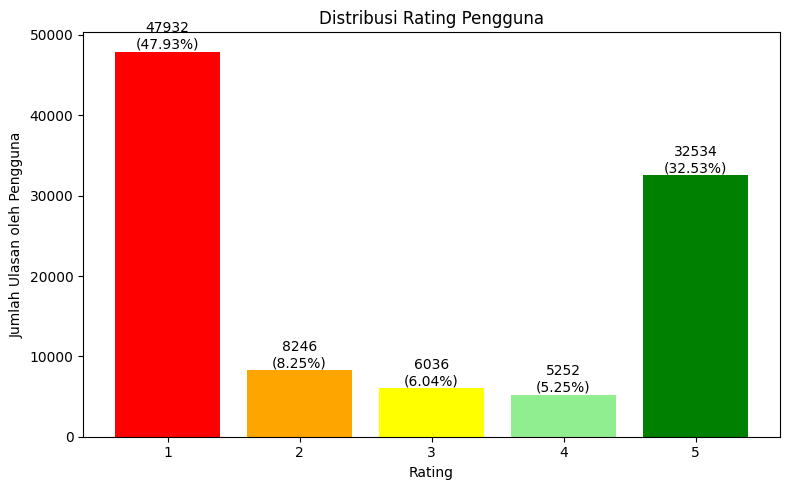

In [6]:
df = pd.read_csv("hasil_scraper_ulasan_APP_1.csv")

# Pastikan rating numerik
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Hitung distribusi rating 1–5
distribusi = (
    df['rating']
    .value_counts()
    .reindex([1, 2, 3, 4, 5], fill_value=0)
    .sort_index()
)

total = distribusi.sum()
persentase = (distribusi / total) * 100

# Warna berbeda untuk tiap rating
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

# Membuat grafik
plt.figure(figsize=(8, 5))
bars = plt.bar(distribusi.index, distribusi.values, color=colors)

plt.xlabel("Rating")
plt.ylabel("Jumlah Ulasan oleh Pengguna")
plt.title("Distribusi Rating Pengguna")
plt.xticks([1, 2, 3, 4, 5])

# Menambahkan jumlah & persentase di atas batang
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}\n({persentase.iloc[i]:.2f}%)",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

# ***Seleksi kolom dan duplikasi***

In [7]:
df_prep = df[['review_txt', 'rating']].copy()

# Cek duplikasi teks
df_prep.duplicated(subset='review_txt').sum()

np.int64(16598)

# ***Membuang Duplikasi***, Membuang duplikasi sejumlah 16.598 data duplikasi akan hilang.

In [8]:
df_prep = df_prep.drop_duplicates(subset='review_txt')
df_prep.shape

(83402, 2)

# ***Case Folding (Mengubah Semua Huruf Menjadi Huruf Kecil)***

In [9]:
#Ambil ulang teks asli
df_prep['review_txt_original'] = df.loc[df_prep.index, 'review_txt']

#Buat hasil case folding dari teks asli
df_prep['review_txt_casefold'] = df_prep['review_txt_original'].str.lower()

#Tampilkan perbandingan
df_prep[['review_txt_original', 'review_txt_casefold']].head(50)

,review_txt_original,review_txt_casefold
0,bagus banget,bagus banget
1,mantap,mantap
2,luar biasa...mantap... terimakasih pelayanan nya,luar biasa...mantap... terimakasih pelayanan nya
3,makin di-update makin banyak masalah nya,makin di-update makin banyak masalah nya
4,"sebenarnya aplikasi ini memudahkan,tp knp bebe...","sebenarnya aplikasi ini memudahkan,tp knp bebe..."
5,sngt membatu,sngt membatu
6,kenapa war tiket lebaran tahun ini susah bange...,kenapa war tiket lebaran tahun ini susah bange...
7,cepat,cepat
9,good,good
10,sangat keren,sangat keren


# ***Cleaning Teks***

In [10]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)      # hapus URL
    text = re.sub(r'[^a-z\s]', ' ', text)    # hapus angka & simbol
    text = re.sub(r'\s+', ' ', text).strip() # rapikan spasi
    return text

df_prep['review_txt_clean'] = df_prep['review_txt_casefold'].apply(clean_text)

df_prep[['review_txt_casefold', 'review_txt_clean']].head(50)

,review_txt_casefold,review_txt_clean
0,bagus banget,bagus banget
1,mantap,mantap
2,luar biasa...mantap... terimakasih pelayanan nya,luar biasa mantap terimakasih pelayanan nya
3,makin di-update makin banyak masalah nya,makin di update makin banyak masalah nya
4,"sebenarnya aplikasi ini memudahkan,tp knp bebe...",sebenarnya aplikasi ini memudahkan tp knp bebe...
5,sngt membatu,sngt membatu
6,kenapa war tiket lebaran tahun ini susah bange...,kenapa war tiket lebaran tahun ini susah bange...
7,cepat,cepat
9,good,good
10,sangat keren,sangat keren


# ***Menghapus Stopword (Kata Tidak Bermakna)***

In [22]:
# Install Sastrawi (hanya perlu sekali)
!pip install Sastrawi

# Import library stopword
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()

# Fungsi hapus stopword
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

# Terapkan ke kolom clean
df_prep['review_txt_nostop'] = df_prep['review_txt_clean'].apply(remove_stopwords)

# Tampilkan perbandingan
df_prep[['review_txt_clean', 'review_txt_nostop']].head(50)

,review_txt_clean,review_txt_nostop
0,bagus banget,bagus banget
1,mantap,mantap
2,luar biasa mantap terimakasih pelayanan nya,luar biasa mantap terimakasih pelayanan nya
3,makin di update makin banyak masalah nya,makin update makin banyak masalah nya
4,sebenarnya aplikasi ini memudahkan tp knp bebe...,sebenarnya aplikasi memudahkan tp knp beberapa...
5,sngt membatu,sngt membatu
6,kenapa war tiket lebaran tahun ini susah bange...,war tiket lebaran tahun susah banget min udah ...
7,cepat,cepat
9,good,good
10,sangat keren,sangat keren


# ***Tokenisasi***

In [24]:
# Tokenisasi sederhana: split berdasarkan spasi
df_prep['review_tokens'] = df_prep['review_txt_nostop'].apply(lambda x: x.split())

# Tampilkan perbandingan untuk 5 baris pertama
df_prep[['review_txt_nostop', 'review_tokens']].head(50)

,review_txt_nostop,review_tokens
0,bagus banget,"[bagus, banget]"
1,mantap,[mantap]
2,luar biasa mantap terimakasih pelayanan nya,"[luar, biasa, mantap, terimakasih, pelayanan, ..."
3,makin update makin banyak masalah nya,"[makin, update, makin, banyak, masalah, nya]"
4,sebenarnya aplikasi memudahkan tp knp beberapa...,"[sebenarnya, aplikasi, memudahkan, tp, knp, be..."
5,sngt membatu,"[sngt, membatu]"
6,war tiket lebaran tahun susah banget min udah ...,"[war, tiket, lebaran, tahun, susah, banget, mi..."
7,cepat,[cepat]
9,good,[good]
10,sangat keren,"[sangat, keren]"


# ***Stemming*** (Mengubah Kata ke Bentuk Dasar)

In [26]:
# Install Sastrawi (jika belum)
!pip install Sastrawi

# Import stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi stemming per token
def stem_tokens(tokens):
    # tokens di sini adalah list kata hasil tokenisasi
    return [stemmer.stem(token) for token in tokens]

# Terapkan ke kolom hasil tokenisasi
df_prep['review_tokens_stemmed'] = df_prep['review_tokens'].apply(stem_tokens)

# Jika ingin kembali menjadi string untuk TF-IDF / WordCloud
df_prep['review_txt_stemmed'] = df_prep['review_tokens_stemmed'].apply(lambda x: ' '.join(x))

# Tampilkan hasil
df_prep[['review_tokens', 'review_tokens_stemmed', 'review_txt_stemmed']].head(10)

,review_tokens,review_tokens_stemmed,review_txt_stemmed
0,"[bagus, banget]","[bagus, banget]",bagus banget
1,[mantap],[mantap],mantap
2,"[luar, biasa, mantap, terimakasih, pelayanan, ...","[luar, biasa, mantap, terimakasih, layan, nya]",luar biasa mantap terimakasih layan nya
3,"[makin, update, makin, banyak, masalah, nya]","[makin, update, makin, banyak, masalah, nya]",makin update makin banyak masalah nya
4,"[sebenarnya, aplikasi, memudahkan, tp, knp, be...","[benar, aplikasi, mudah, tp, knp, beberapa, ha...",benar aplikasi mudah tp knp beberapa hari susa...
5,"[sngt, membatu]","[sngt, batu]",sngt batu
6,"[war, tiket, lebaran, tahun, susah, banget, mi...","[war, tiket, lebaran, tahun, susah, banget, mi...",war tiket lebaran tahun susah banget min udah ...
7,[cepat],[cepat],cepat
9,[good],[good],good
10,"[sangat, keren]","[sangat, keren]",sangat keren


# ***Tahap Labeling***

In [27]:
# Fungsi untuk assign sentimen
def assign_sentiment(rating):
    if rating >= 4:
        return 'positif'
    elif rating == 3:
        return 'netral'
    else:
        return 'negatif'

# Terapkan ke kolom rating
df_prep['sentiment'] = df_prep['rating'].apply(assign_sentiment)

# Cek distribusi
print(df_prep['sentiment'].value_counts())

# Tampilkan beberapa baris pertama (50 baris)
df_prep[['review_txt_stemmed', 'rating', 'sentiment']].head(50)

sentiment
negatif    54544
positif    23162
netral      5696
Name: count, dtype: int64


,review_txt_stemmed,rating,sentiment
0,bagus banget,5,positif
1,mantap,5,positif
2,luar biasa mantap terimakasih layan nya,5,positif
3,makin update makin banyak masalah nya,1,negatif
4,benar aplikasi mudah tp knp beberapa hari susa...,5,positif
5,sngt batu,5,positif
6,war tiket lebaran tahun susah banget min udah ...,5,positif
7,cepat,5,positif
9,good,5,positif
10,sangat keren,5,positif


# ***TF-IDF Vectorization***

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gunakan kolom hasil stemming
corpus = df_prep['review_txt_stemmed']

# Buat vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,     # ambil 5000 kata paling penting
    ngram_range=(1,2),     # unigram + bigram
    min_df=3,              # kata muncul minimal 3 dokumen
    max_df=0.9             # kata muncul di >90% dokumen diabaikan
)

# Fit dan transformasi teks menjadi matriks TF-IDF
X = tfidf.fit_transform(corpus)

# Target label: sentiment yang sudah dibuat
y = df_prep['sentiment']

# Cek bentuk matriks
print("Bentuk matriks TF-IDF:", X.shape)

Bentuk matriks TF-IDF: (83402, 5000)


# ***Split Data Train & Test (Revisi Ulasan)***

In [29]:
from sklearn.model_selection import train_test_split

# Split data TF-IDF menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Cek ukuran data dan distribusi label
print("Ukuran X_train:", X_train.shape)
print("Ukuran X_test:", X_test.shape)
print("Distribusi label di data train:\n", y_train.value_counts())
print("Distribusi label di data test:\n", y_test.value_counts())

Ukuran X_train: (66721, 5000)
Ukuran X_test: (16681, 5000)
Distribusi label di data train:
 sentiment
negatif    43635
positif    18529
netral      4557
Name: count, dtype: int64
Distribusi label di data test:
 sentiment
negatif    10909
positif     4633
netral      1139
Name: count, dtype: int64


# ***Training Model SVM***

In [30]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

# Buat model SVM
svm_model = LinearSVC(random_state=42, max_iter=10000)

# Training model dengan data latih
svm_model.fit(X_train, y_train)

# Prediksi data uji
y_pred = svm_model.predict(X_test)

# Evaluasi performa
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[10334    30   545]
 [  905    12   222]
 [ 1030    12  3591]]

Classification Report:
              precision    recall  f1-score   support

     negatif       0.84      0.95      0.89     10909
      netral       0.22      0.01      0.02      1139
     positif       0.82      0.78      0.80      4633

    accuracy                           0.84     16681
   macro avg       0.63      0.58      0.57     16681
weighted avg       0.79      0.84      0.81     16681



# ***Pembuatan Word Cloud***

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis'  # bisa diganti sesuai preferensi
    ).generate(text)

    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# ***WordCloud Positif***

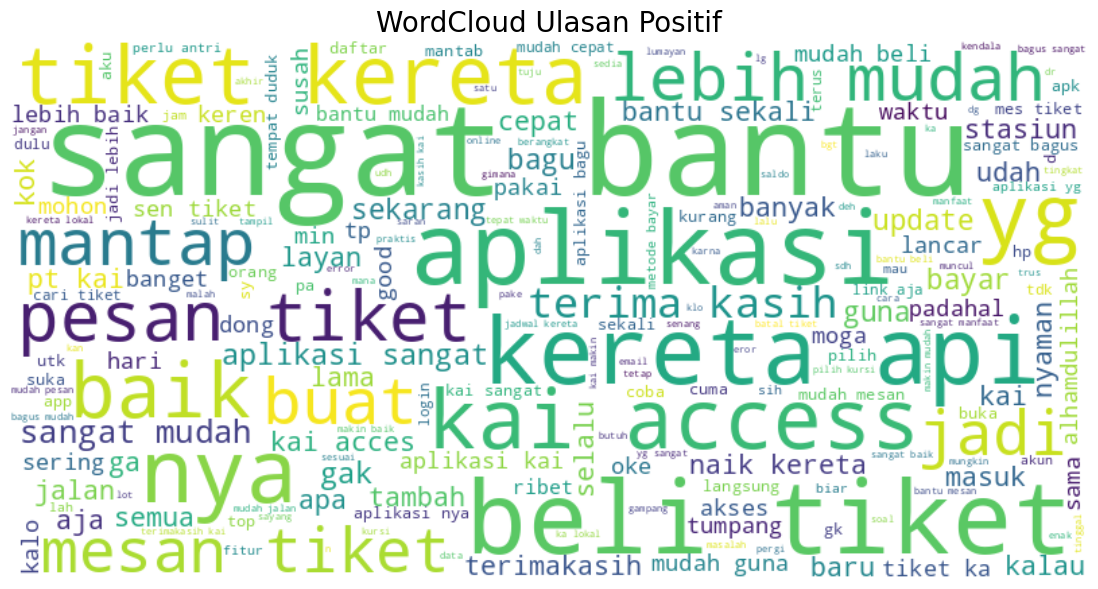

In [32]:

# Gabungkan semua ulasan positif
text_pos = ' '.join(df_prep[df_prep['sentiment']=='positif']['review_txt_stemmed'].tolist())

# Tampilkan WordCloud
plot_wordcloud(text_pos, "WordCloud Ulasan Positif")

# ***Word Cloud Ulasan Netral***

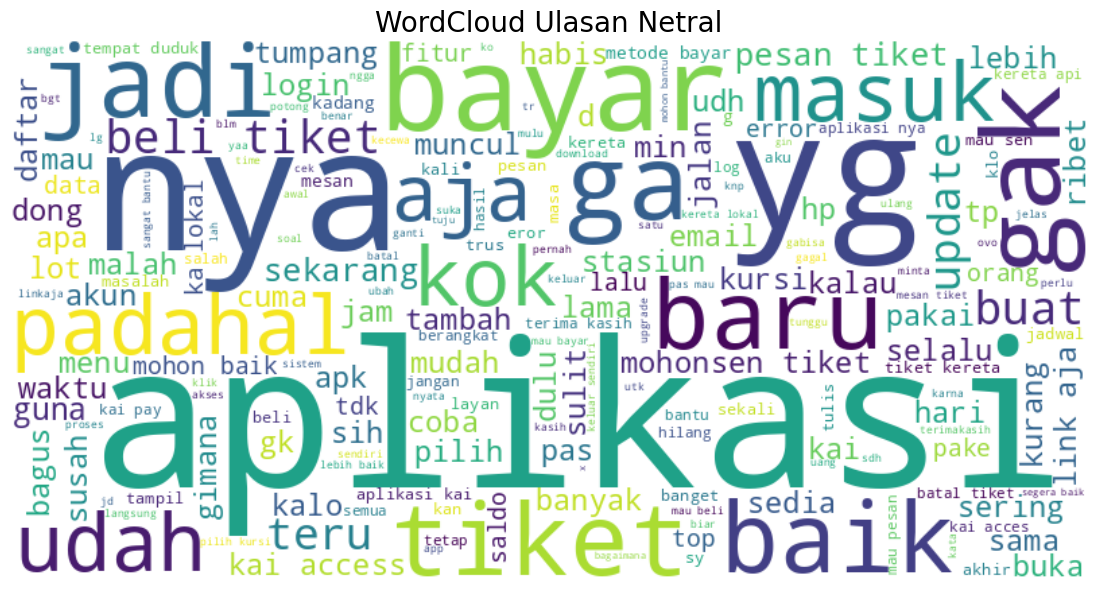

In [33]:
# Gabungkan semua ulasan netral
text_neutral = ' '.join(df_prep[df_prep['sentiment']=='netral']['review_txt_stemmed'].tolist())

# Tampilkan WordCloud
plot_wordcloud(text_neutral, "WordCloud Ulasan Netral")



# ***Word CLoud Ulasan Negatif***

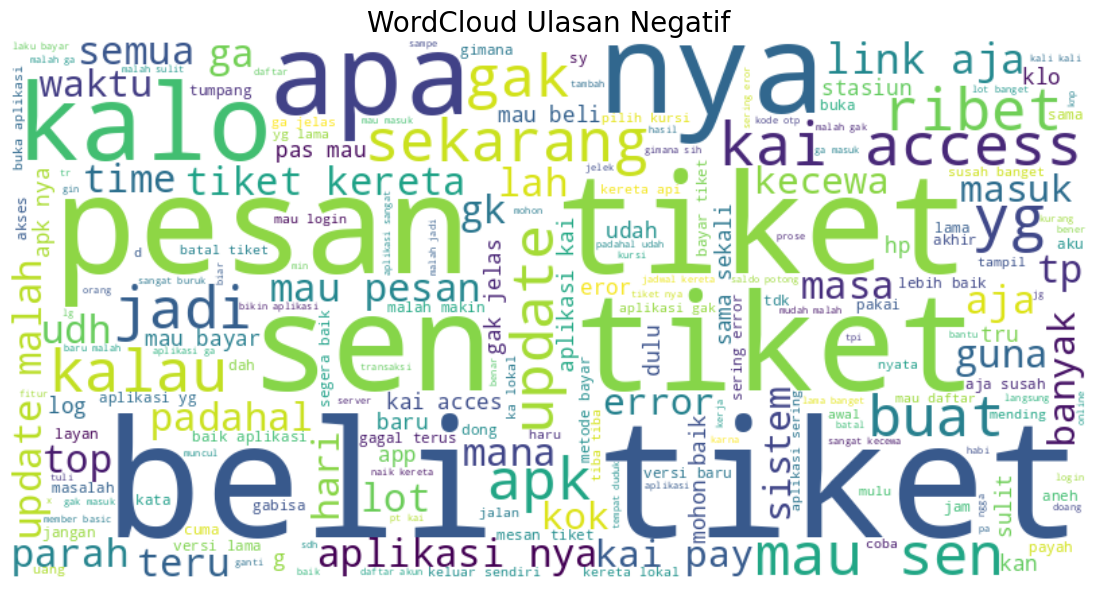

In [34]:
# Gabungkan semua ulasan negatif
text_neg = ' '.join(df_prep[df_prep['sentiment']=='negatif']['review_txt_stemmed'].tolist())

# Tampilkan WordCloud
plot_wordcloud(text_neg, "WordCloud Ulasan Negatif")

# ***Top 10 Kata per Sentimen***

In [36]:
import pandas as pd
from collections import Counter

# Fungsi untuk menghitung top n kata
def top_n_words(text_series, n=10):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# ***Top 10 Kata Positif***

In [37]:

# 1️⃣ Top 10 Kata Positif
top_pos = top_n_words(df_prep[df_prep['sentiment']=='positif']['review_txt_stemmed'], 10)
df_top_pos = pd.DataFrame(top_pos, columns=['Kata', 'Frekuensi'])
print("Top 10 Kata Positif:")
display(df_top_pos)

Top 10 Kata Positif:


,Kata,Frekuensi
0,tiket,5280
1,mudah,4747
2,sangat,4551
3,kai,4346
4,aplikasi,3940
5,bantu,3352
6,kereta,2803
7,bagus,2226
8,lebih,2040
9,baik,1869


# ***Top 10 Kata Negatif***

In [38]:

# 3️⃣ Top 10 Kata Negatif
top_neg = top_n_words(df_prep[df_prep['sentiment']=='negatif']['review_txt_stemmed'], 10)
df_top_neg = pd.DataFrame(top_neg, columns=['Kata', 'Frekuensi'])
print("Top 10 Kata Negatif:")
display(df_top_neg)

Top 10 Kata Negatif:


,Kata,Frekuensi
0,aplikasi,23052
1,tiket,20166
2,mau,11621
3,gak,9974
4,nya,9775
5,ga,9592
6,bayar,9406
7,malah,9280
8,kai,8454
9,aja,7944


# ***Top 10 Kata Netral***

In [39]:
# 2️⃣ Top 10 Kata Netral
top_neutral = top_n_words(df_prep[df_prep['sentiment']=='netral']['review_txt_stemmed'], 10)
df_top_neutral = pd.DataFrame(top_neutral, columns=['Kata', 'Frekuensi'])
print("Top 10 Kata Netral:")
display(df_top_neutral)

Top 10 Kata Netral:


,Kata,Frekuensi
0,tiket,2006
1,aplikasi,1661
2,bayar,1186
3,mau,1115
4,nya,1002
5,kai,968
6,baik,950
7,yg,861
8,gak,706
9,update,673


# ***Gabungan Seluruh Sentimen***

In [40]:
import pandas as pd
from collections import Counter

# Fungsi menghitung Top N kata
def top_n_words(text_series, n=10):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Ambil Top 10 kata tiap sentimen
top_pos = top_n_words(df_prep[df_prep['sentiment']=='positif']['review_txt_stemmed'], 10)
top_neutral = top_n_words(df_prep[df_prep['sentiment']=='netral']['review_txt_stemmed'], 10)
top_neg = top_n_words(df_prep[df_prep['sentiment']=='negatif']['review_txt_stemmed'], 10)

# Gabungkan menjadi satu DataFrame
df_top_words = pd.DataFrame({
    'Kata Positif': [w[0] for w in top_pos],
    'Frekuensi Positif': [w[1] for w in top_pos],
    'Kata Netral': [w[0] for w in top_neutral],
    'Frekuensi Netral': [w[1] for w in top_neutral],
    'Kata Negatif': [w[0] for w in top_neg],
    'Frekuensi Negatif': [w[1] for w in top_neg]
})

# Tampilkan tabel
df_top_words

,Kata Positif,Frekuensi Positif,Kata Netral,Frekuensi Netral,Kata Negatif,Frekuensi Negatif
0,tiket,5280,tiket,2006,aplikasi,23052
1,mudah,4747,aplikasi,1661,tiket,20166
2,sangat,4551,bayar,1186,mau,11621
3,kai,4346,mau,1115,gak,9974
4,aplikasi,3940,nya,1002,nya,9775
5,bantu,3352,kai,968,ga,9592
6,kereta,2803,baik,950,bayar,9406
7,bagus,2226,yg,861,malah,9280
8,lebih,2040,gak,706,kai,8454
9,baik,1869,update,673,aja,7944


# **Bar Chart Top 10 Kata per Sentimen**

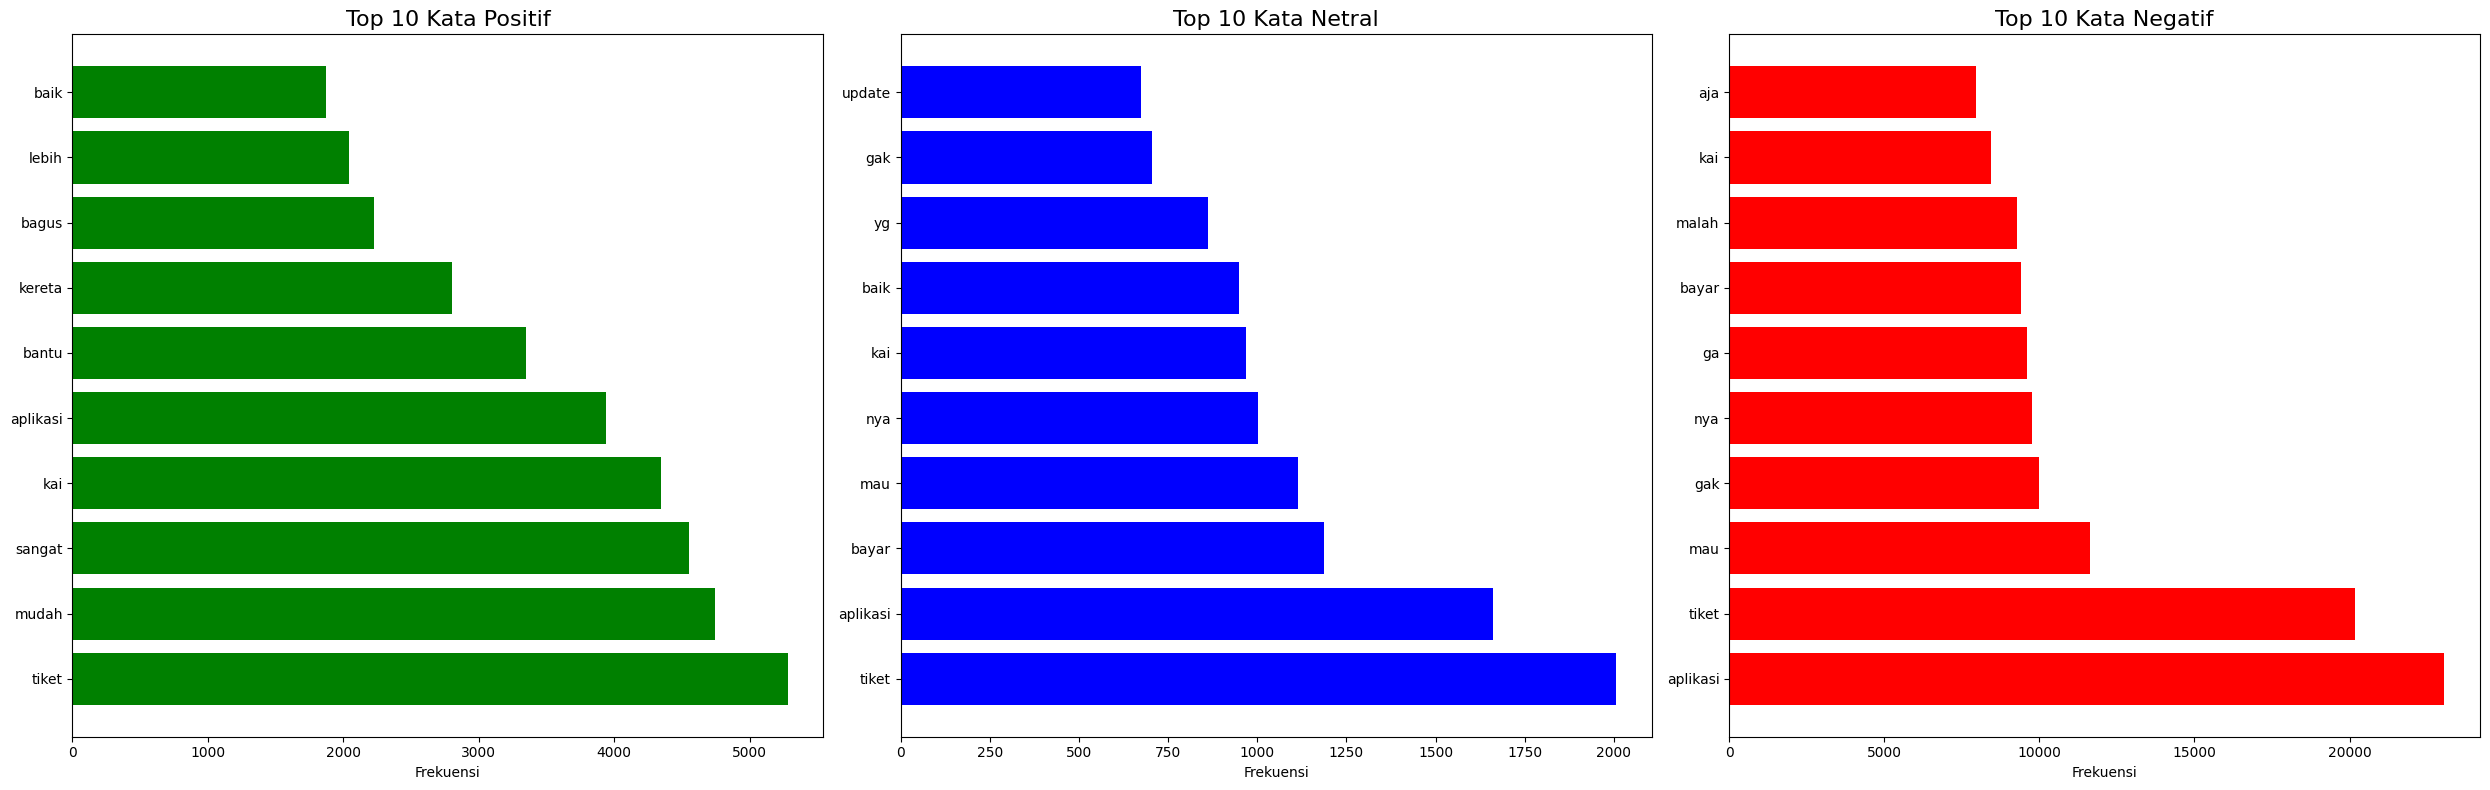

In [41]:
import matplotlib.pyplot as plt

# Buat figure dengan 3 subplot berdampingan
fig, axes = plt.subplots(1, 3, figsize=(25, 8))

# Positif
axes[0].barh([w[0] for w in top_pos][::-1], [w[1] for w in top_pos][::-1], color='green')
axes[0].set_title('Top 10 Kata Positif', fontsize=16)
axes[0].set_xlabel('Frekuensi')
axes[0].invert_yaxis()  # kata terbanyak di atas

# Netral
axes[1].barh([w[0] for w in top_neutral][::-1], [w[1] for w in top_neutral][::-1], color='blue')
axes[1].set_title('Top 10 Kata Netral', fontsize=16)
axes[1].set_xlabel('Frekuensi')
axes[1].invert_yaxis()

# Negatif
axes[2].barh([w[0] for w in top_neg][::-1], [w[1] for w in top_neg][::-1], color='red')
axes[2].set_title('Top 10 Kata Negatif', fontsize=16)
axes[2].set_xlabel('Frekuensi')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# ***Kombinasi WordCloud + Bar Chart per Sentimen***

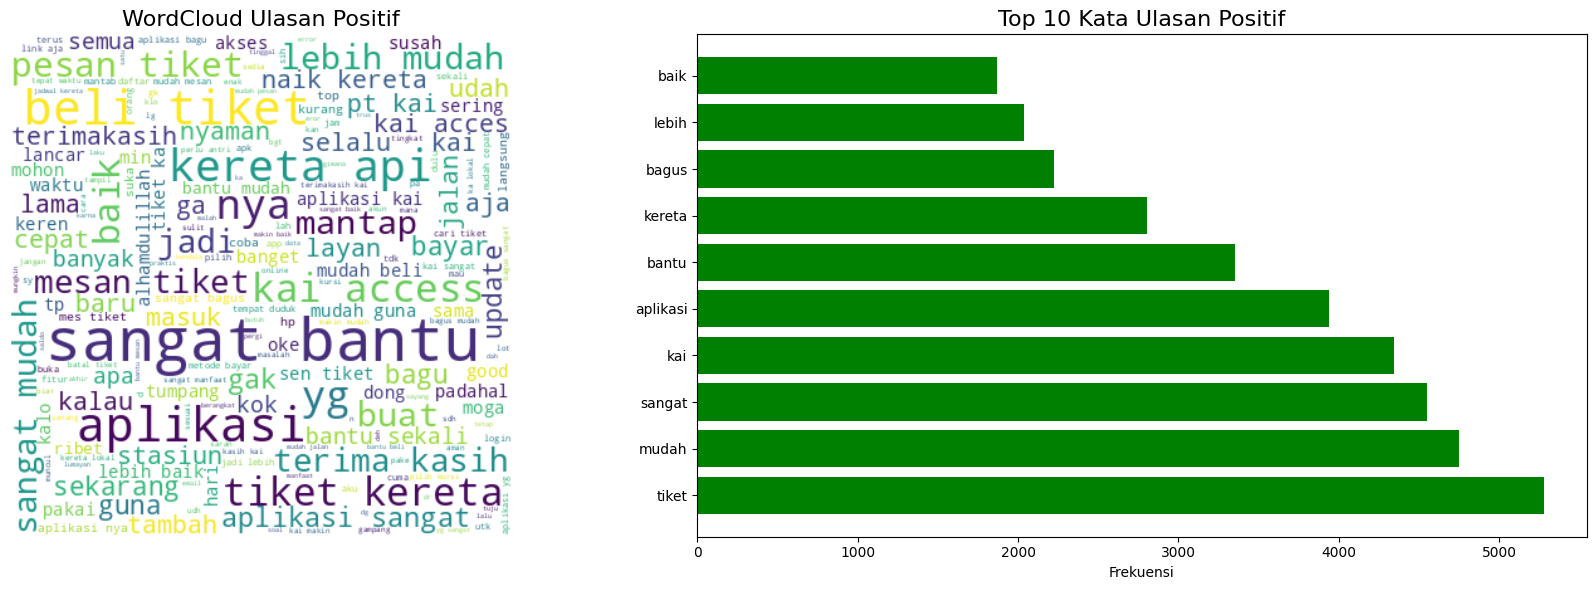

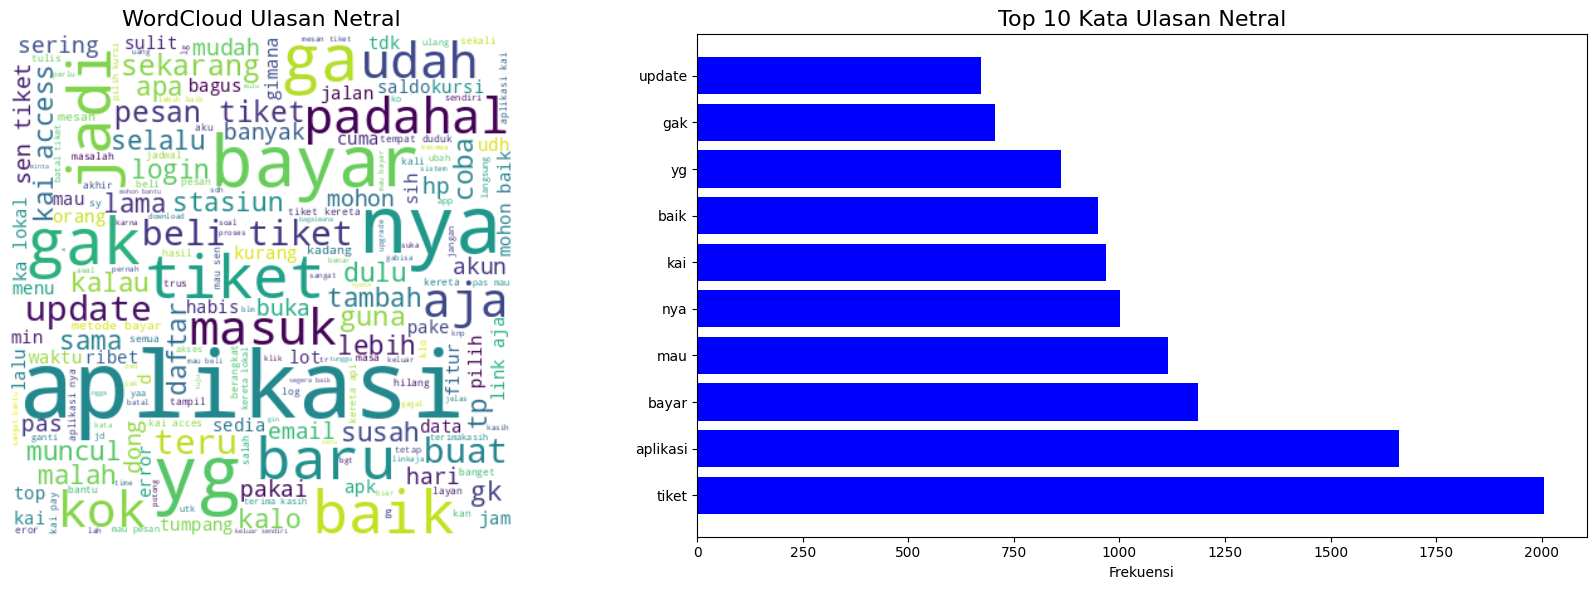

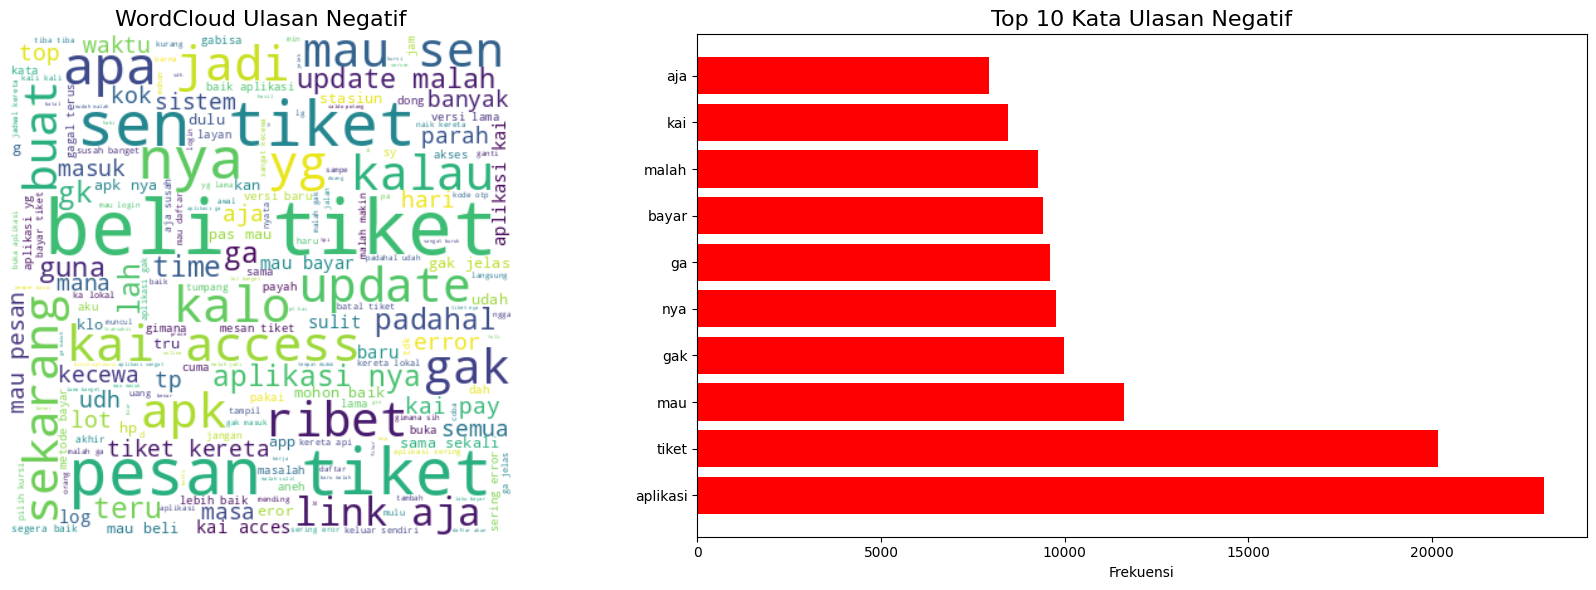

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Fungsi WordCloud
def generate_wordcloud(text):
    return WordCloud(
        width=400,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate(text)

# Fungsi Top N kata
def top_n_words(text_series, n=10):
    all_words = ' '.join(text_series).split()
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Persiapkan data per sentimen
sentiments = ['positif', 'netral', 'negatif']
colors = {'positif':'green', 'netral':'blue', 'negatif':'red'}

for sentiment in sentiments:
    # Gabungkan teks
    text = ' '.join(df_prep[df_prep['sentiment']==sentiment]['review_txt_stemmed'].tolist())
    top_words = top_n_words(df_prep[df_prep['sentiment']==sentiment]['review_txt_stemmed'], 10)

    # Buat figure dengan 2 subplot
    fig, axes = plt.subplots(1, 2, figsize=(18,6))

    # WordCloud
    wc = generate_wordcloud(text)
    axes[0].imshow(wc, interpolation='bilinear')
    axes[0].axis('off')
    axes[0].set_title(f'WordCloud Ulasan {sentiment.capitalize()}', fontsize=16)

    # Bar Chart Top 10 kata
    axes[1].barh([w[0] for w in top_words][::-1], [w[1] for w in top_words][::-1], color=colors[sentiment])
    axes[1].set_xlabel('Frekuensi')
    axes[1].invert_yaxis()
    axes[1].set_title(f'Top 10 Kata Ulasan {sentiment.capitalize()}', fontsize=16)

    plt.tight_layout()
    plt.show()

# ***Confusion Matrix***

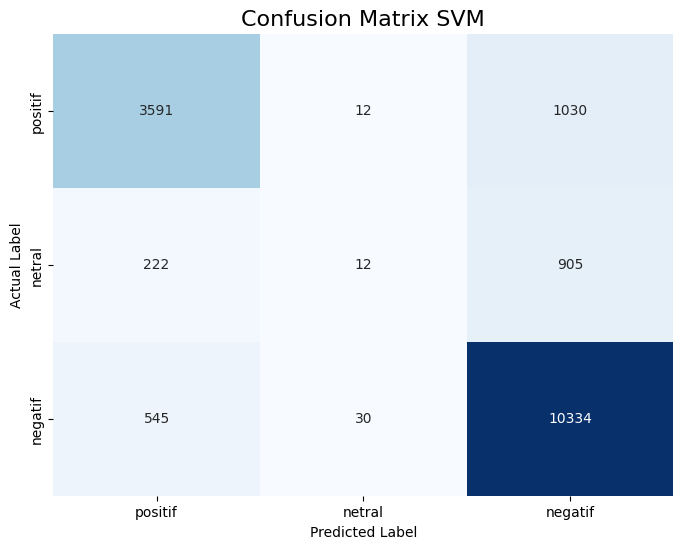

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positif', 'netral', 'negatif'])

# Buat DataFrame untuk label yang jelas
cm_df = pd.DataFrame(cm, index=['positif','netral','negatif'], columns=['positif','netral','negatif'])

# Visualisasi heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix SVM', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ***Graph***

/tmp/ipython-input-2954741660.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['green','blue','red'])


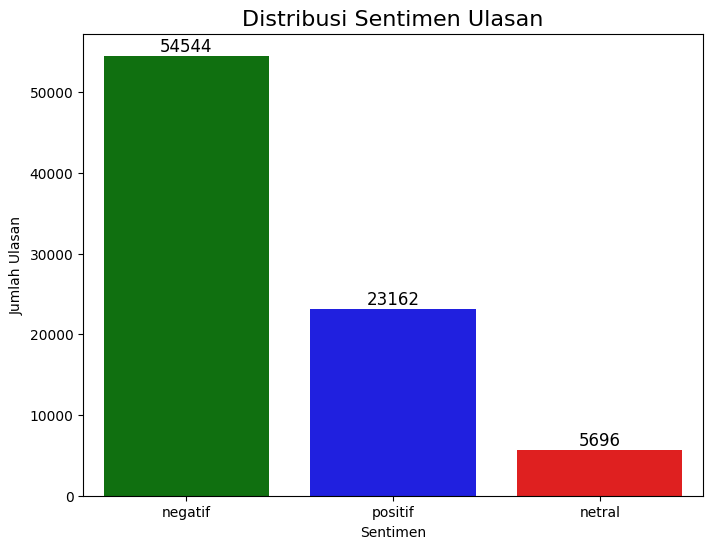

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah ulasan per sentimen
sentiment_counts = df_prep['sentiment'].value_counts()

# Buat bar chart
plt.figure(figsize=(8,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['green','blue','red'])
plt.title('Distribusi Sentimen Ulasan', fontsize=16)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Ulasan')
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12)  # menambahkan angka di atas batang
plt.show()